# GM_diatomic_A code

In [4]:
import os
import numpy as np
from scipy.special import erf, erfinv
#from math import erf
from numpy.linalg import norm
from mlmm import VelocityData, plot_learn_curve, n_fold_cv, fileinfo,VelocityDataOmegaData, OmegaData

import matplotlib.pyplot as plt

from datetime import date
today = date.today().strftime("%b-%d-%Y")
import periodictable

import sys
from mlmm import func_postprocess
import time



er_type = 'MAE'

system_6D = True # Assignment A uses 6D data since we are using only the translational velocity data
system_10D = False
system_omega = False # Set to false, since we are not using angular velocity data in this assignment
wall_temp = 300
Liao_Transfer_Function = True

kB,conv_v,conv_omega,av_num = 1.38064852e-23,1.0e2,1.0e12,6.022e23




x_data = [
          ]
y_data = [
          ]

x_omega = []
y_omega = []

x_MD = []
y_MD = []

# Path to the data files for Task 1
# Materials_for_ML_assignment\H2_IsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_T500_Tb_300.txt  
# Materials_for_ML_assignment\H2_NonIsoThermalWalls_Sw_0\H2_Vel_MD_Sw_0_B300_Th_500.txt

path_to_data = 'Data_H2_assignment_A'
path_save_data='./'+path_to_data
#path_to_data = 'Shahin/test_data/'



for file in os.listdir(path_to_data):

    if file.endswith(".txt") and "MD" in file:
        x_MD.append(os.path.join(path_to_data,file))
        y_MD.append('')

    if file.endswith(".txt") and "omega" in file:
        x_omega.append(os.path.join(path_to_data,file))
        y_omega.append('')
print("Data files found:",x_MD)


######################################################################################
#------------------------------- Getting translational velocity data
####--------------------------------------------------------------------------------------------------
for x_data_file,y_data_file in zip(x_MD,y_MD):
    

    conf = VelocityData(x_data_file, frames=None)#[0,30000])
    conf.getRep(rep='vxvyvz',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
    file_name=x_data_file.replace('.','/')
    file_name=file_name.split('/')
    set_name = file_name[1]
    X = conf.X
    y = conf.y
    if "He" in path_to_data:
        mass = getattr(periodictable,'He').mass
        gas_name = 'He'
    elif "Ar" in path_to_data:
        mass = getattr(periodictable,'Ar').mass
        gas_name = 'Ar'
    elif "H2" in path_to_data:
        mass =2* getattr(periodictable,'H').mass
        gas_name = 'H2'
        l_b=0.741e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    elif "N2" in path_to_data:
        mass =2* getattr(periodictable,'N').mass
        gas_name = 'N2'
        l_b=1.097e-10
        mass_kg = mass * 0.001 / av_num
        I=(mass_kg/4)*l_b**2
    else:
        print ("Unable to identify impinging atom type...")
        ele = str(input("Enter the impinging atom symbol : "))
        mass = getattr(periodictable,ele).mass
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
    print ('Atomic mass for {} molecule is {:1.4f} \n'.format(gas_name,mass))
    n_MD = X.shape[0]
    print('Number of MD tr velocity data points: {} \n'.format(n_MD))
    # Implementing Liao Transfer function on perpendicular velocity component
    v_TF,T_in,T_out,theta_in,theta_out=func_postprocess.liao_transform(X,mass,'y')


######################################################################################
#------------------------------- Getting angular velocity data
####--------------------------------------------------------------------------------------------------
if system_omega:
    for x_data_file2,y_data_file2 in zip(x_omega,y_omega):
        #conf2 = OmegaData(x_data_file2, frames=frames)#[0,30000])
        conf2 = OmegaData(x_data_file2, frames=None)#[0,30000])
        conf2.getRep(rep='omega1omega2',nuc=None) #rep options: vxvyvz, vel2norm, vx2,vy2,vz2,vx,vy,vz
        omega_file_name = x_data_file2.replace('.','/')
        omega_file_name = omega_file_name.split('/')
        omega_name = omega_file_name[1]
        print(omega_name)
        X2 = conf2.X2
        y2 = conf2.y2
        print('Number of MD rot velocity data points: {} \n'.format(X2.shape[0]))
        X2_TF=np.copy(X2)
        Y2_TF=np.copy(y2)
        omega_TF=np.vstack((X2_TF,-X2_TF))
        y2_TF=np.hstack((Y2_TF,-Y2_TF))   

######################################################################################
#------------------------------- Implementing GM model on 10D data
####--------------------------------------------------------------------------------------------------                   

if system_10D:
    vel_tr = np.copy(X)
    vel_tr[:,1]=np.abs(vel_tr[:,1])
    vel_tr[:,4]=np.abs(vel_tr[:,4])
    data_for_AC_MD = np.concatenate((vel_tr,X2),axis=1)

    
    if Liao_Transfer_Function:
        #omega_bond = np.copy(X2)
        v_tr=np.copy(v_TF[:n_MD,:])
        v_omega = np.copy(X2)
        v_mp = np.sqrt(2 * kB * wall_temp / mass_kg)
        omega_mp = np.sqrt(2 * kB * wall_temp / I)
        #--- Normalazing the translational and rotational velocities
        data_train_10D = np.concatenate((v_tr*conv_v/v_mp,X2*conv_omega/omega_mp),axis=1)

        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))
        
    else:
        data_train_10D = data_for_AC_MD
        print('The total number of training points is: {} \n'.format(data_train_10D.shape[0]))

Data files found: ['Data_H2_assignment_A\\H2_Vel_MD_Sw_0_B300_Th_300.txt', 'Data_H2_assignment_A\\H2_Vel_MD_Sw_0_B300_Th_500.txt', 'Data_H2_assignment_A\\H2_Vel_MD_Sw_0_T500_Tb_300.txt']
Generating Representation


0% [#                             ] 100% | ETA: 00:00:01

Not a float


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Atomic mass for H2 molecule is 2.0160 

Number of MD tr velocity data points: 123351 

Generating Representation


0% [##                            ] 100% | ETA: 00:00:02

Not a float


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:03


Atomic mass for H2 molecule is 2.0160 

Number of MD tr velocity data points: 330030 

Generating Representation


0% [##                            ] 100% | ETA: 00:00:01

Not a float


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:02


Atomic mass for H2 molecule is 2.0160 

Number of MD tr velocity data points: 325627 



## Gaussian Mixture model with PCA

### Analyze the data

In [83]:
# 1 GMM with PCA
import pandas as pd
X_df = pd.DataFrame(X, columns=['vx_in', 'vy_in', 'vz_in', 'vx_out', 'vy_out', 'vz_out'], copy=True)

X_in = np.copy(X[:,:3])
X_out = np.copy(X[:,3:])

X_df = X_df[:5000] # Take small percentage of data for testing
X_df

,vx_in,vy_in,vz_in,vx_out,vy_out,vz_out
0,31.369250,34.472250,-0.362050,-31.254500,-15.562605,-9.206793
1,-8.783005,4.194468,2.742670,-11.766105,-3.531000,-7.019935
2,5.179750,16.538545,10.050730,20.902230,-18.651150,-8.930650
3,-13.402535,6.330900,-3.605180,13.389870,-15.865365,-13.684030
4,12.760400,12.537950,-3.191795,15.201050,-19.842515,18.374620
...,...,...,...,...,...,...
4995,-1.769632,5.178745,12.623540,-4.214460,-4.733610,2.142750
4996,5.437665,12.025300,4.400275,-17.244000,-4.351315,1.666562
4997,-20.099950,1.866860,7.171435,-4.851855,-12.064335,-6.300445
4998,-7.453885,19.190050,-7.516580,-4.462529,-18.159650,-3.134155


### Decide on model parameters

In [ ]:
import numpy as np
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Current best estimate for specs: covariance_type='diag', n_components=3

bic = np.zeros(5)
for nr_components in range(1,5):
    gmm_model = GaussianMixture(n_components=nr_components, random_state=0)
    gmm_model.fit(X_df)


In [13]:
from sklearn.model_selection import GridSearchCV
def gmm_bic_score(estimator, X):
    """Callable to pass to GridSearchCV that will use the BIC score."""
    # Make it negative since GridSearchCV expects a score to maximize
    return -estimator.bic(X)

param_grid = {
    "n_components": range(1, 7),
    "covariance_type": ["spherical", "tied", "diag", "full"],
}

grid_search = GridSearchCV(
    GaussianMixture(), param_grid=param_grid, scoring=gmm_bic_score
)

grid_search.fit(X_df)

GridSearchCV(estimator=GaussianMixture(),
             param_grid={'covariance_type': ['spherical', 'tied', 'diag',
                                             'full'],
                         'n_components': range(1, 7)},
             scoring=<function gmm_bic_score at 0x000001589EC179A0>)

## Train GMM model

In [ ]:
nr_components = 3
covariance_type = 'diag'
gmm_model = GaussianMixture(n_components=nr_components, covariance_type=covariance_type, random_state=0)
gmm_model.fit(X_df)



GaussianMixture(covariance_type='diag', n_components=3, random_state=0)

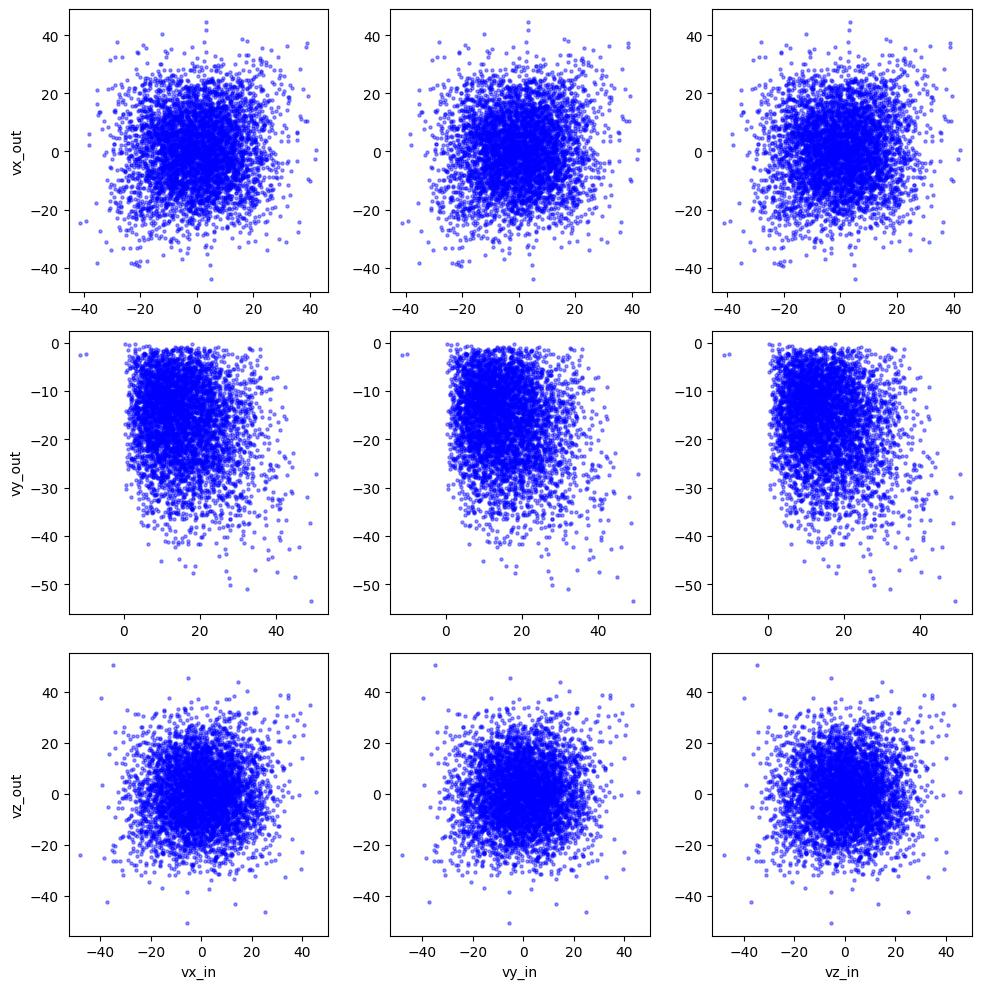

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# TODO Fix the indexing so that the v_in is not the same for each plot
fig, ax = plt.subplots(3,3, figsize=(10,10))
labels = ["x", "y", "z"]
for row in range(3):
    ax[row,0].set_ylabel(f'v{labels[row]}_out')  
    ax[2,row].set_xlabel(f'v{labels[row]}_in')
    v_in = X_df.iloc[:,row]
    v_out = X_df.iloc[:,row+3]
    for column in range(3):
        ax[row,column].scatter(v_in, v_out, c='blue',s=5, alpha=0.4, label='Data points')
plt.tight_layout()
plt.show()

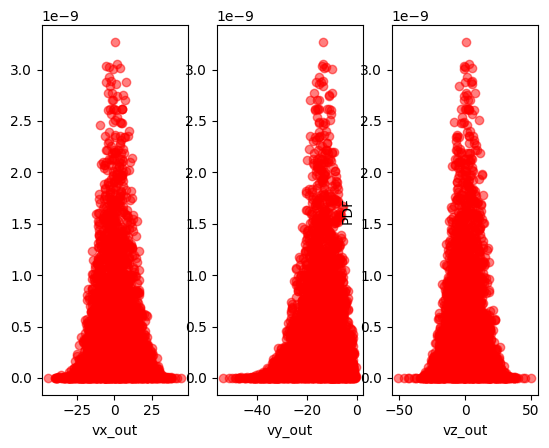

In [64]:
logprob = gmm_model.score_samples(X_df)

# Extract the pdf from the GMM model
fig, ax = plt.subplots(1,3)
labels = ["vx_out", "vy_out", "vz_out"]

for row in range(3):
    pdf = np.exp(logprob)
    v_out = X_df.iloc[:,3+row]

    # Visualize the pdf against the v_out (either vx_out, vy_out or vz_out)
    ax[row].scatter(v_out, pdf, c='red', alpha=0.5, label='PDF')
    ax[row].set_xlabel(f'{labels[row]}')

plt.ylabel("PDF")
plt.show()